In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch
 
from gptopt.optim.pdhg import *
from gptopt.optim.fast_pdhg import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Solving problem 
$$
\begin{array}{ll}
\text{minimize} & q(z) + h(x) \\
\text{subject to} & x = Az
\end{array}
$$

### Special case
$$
\begin{array}{ll}
\text{minimize} & g^\top z  \\
\text{subject to} & \|Az\|_{\max} \leq \beta 
\end{array}
$$
where $g \in \mathcal{R}(A^\top)$

## PDHG 
$$
\begin{aligned}
y^{t+1} &= \operatorname{prox}_{\rho h^*}\!\bigl(y^t + \rho\, A(2 z^t - z^{t-1})\bigr), \\
z^{t+1} &= \operatorname{prox}_{\gamma q}\!\bigl(z^t - \gamma A^\top y^{t+1}\bigr).
\end{aligned}
$$

Residuals
$$
\begin{aligned}
r_1^{t+1} &= \frac{1}{\rho}\left (y^{t+1} - y^t - \rho A(2z^t - z^{t-1} - z^{t+1})\right ) \\
r_2^{t+1} &= \frac{1}{\gamma} \left (z^{t+1} - z^t \right)
\end{aligned}
$$
The stopping cirterion is
$$
\begin{aligned}
 \|r_1^{t+1}\|_2 &\leq \sqrt{m} \, \epsilon^{\mathrm{abs}} + 
 \epsilon^{\mathrm{rel}} \|Az^{t+1}\|_2\\
 \|r_2^{t+1}\|_2 &\leq \sqrt{n} \, \epsilon^{\mathrm{abs}} + 
 \epsilon^{\mathrm{rel}} \|A^\top y^{t+1}\|_2.
\end{aligned}
$$


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )
\end{aligned}
$$


In [3]:
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A1_np = np.random.randn(m, n)
        A2_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = A1_np @ Y0_np.T
        G2_np = A2_np @ Y0_np

        beta = 0.5
        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A2_np, A1_np, beta)

        # Torch tensors
        A2 = torch.from_numpy(A2_np).to(torch.float32).to(device)
        A1 = torch.from_numpy(A1_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z_t, residuals, _ = pdhg_kq_attn_layer(
            prox_h_conj,
            A2=A2,
            A1=A1,
            G1=G1,
            G2=G2,
            max_iter=10000,
            eps_abs=1e-8,
            eps_rel=1e-8,
            stopping=False,
            h_conj=h_conj,
            f_star=f_star,
            beta=beta,
            pd_residuals=pd_residuals_max_ball,
        )

        Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]
        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ A1_np + A2_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ A1_np + A2_np.T @ Z0_2)
        ) <= beta + 1e-3
        print("PASSED")

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED


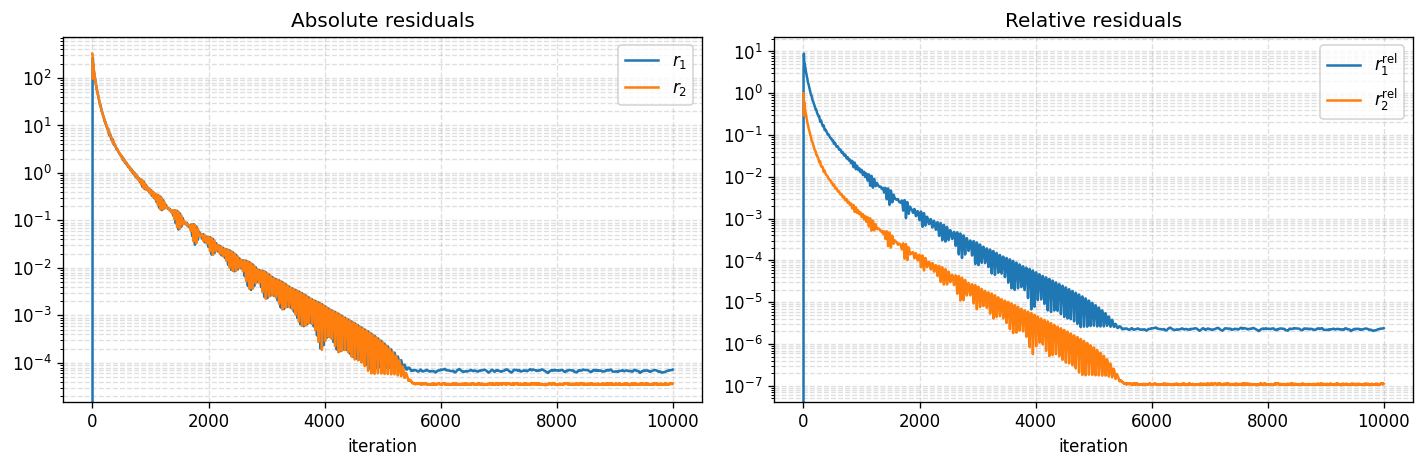

In [4]:
plot_residuals(residuals)

## Dual feasibility checks $\|\mathcal{A}^*(Y) + G\|_F$

In [5]:
for (m, n) in [(30, 60), (60, 30), (60, 60)]:
    print(f"{m}x{n}")
    for _ in range(5):
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        A = torch.from_numpy(A_np).to(torch.float64)
        B = torch.from_numpy(B_np).to(torch.float64)
        G1 = torch.from_numpy(G1_np).to(torch.float64)
        G2 = torch.from_numpy(G2_np).to(torch.float64)

        _, res1 = Y_dual_feasible(A2=A, A1=B, G1=G1, G2=G2, method="lsqr")
        _, res2 = Y_dual_feasible(A2=A.to(torch.float32), A1=B.to(torch.float32), 
                                  G1=G1.to(torch.float32), G2=G2.to(torch.float32), method="lsqr")
        print("residual:", res1["res"], "residual (float32):", res2["res"])

30x60
residual: 7.857218390154141e-07 residual (float32): 9.214343891584895e-07
residual: 8.905994408309088e-07 residual (float32): 1.0142230059301848e-06
residual: 9.86124145635685e-07 residual (float32): 8.599221522105521e-07
residual: 7.320625900495421e-07 residual (float32): 9.082539444495026e-07
residual: 7.456037308828981e-07 residual (float32): 9.040665812792113e-07
60x30
residual: 7.455486354956862e-07 residual (float32): 7.714855870824542e-07
residual: 6.726126212301342e-07 residual (float32): 7.203879947048539e-07
residual: 6.816034691770634e-07 residual (float32): 7.068791353860428e-07
residual: 8.004478046077868e-07 residual (float32): 8.372669191747316e-07
residual: 7.973518173081026e-07 residual (float32): 8.257907346715416e-07
60x60
residual: 9.758106491902002e-07 residual (float32): 1.0933449228436464e-06
residual: 9.967855866160885e-07 residual (float32): 1.1299396242800544e-06
residual: 9.884580884830338e-07 residual (float32): 1.1095902680212893e-06
residual: 9.90267

In [12]:
for (m, n) in [(500, 500)]: 
    # NumPy data for CVXPY reference
    A_np = np.random.randn(m, n)
    B_np = np.random.randn(m, n)
    Y0_np = np.random.randn(n, n)
    G1_np = B_np @ Y0_np.T
    G2_np = A_np @ Y0_np

    beta = 0.5 
    # Torch tensors
    A = torch.from_numpy(A_np).to(torch.float32).to(device)
    B = torch.from_numpy(B_np).to(torch.float32).to(device)
    G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
    G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

    # Y0, dual_res = Y_dual_feasible(A2=A, A1=B, G1=G1, G2=G2)
    # print(f"{dual_res=}")
    Y0 = None

    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    # Run torch PDHG
    Z_t, residuals, _ = pdhg_kq_attn_layer(
        prox_h_conj,
        A2=A,
        A1=B,
        G1=G1,
        G2=G2,
        max_iter=10**4,
        eps_abs=1e-8,
        eps_rel=1e-8,
        stopping=False,
        Y0=Y0,
        h_conj=h_conj,
        beta=beta,
        pd_residuals=pd_residuals_max_ball,
        diag_scaling=False,
        equilibration=False, 
    )

    # Back to NumPy for comparison
    Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]
    Z1 = Z1_t.cpu().numpy()
    Z2 = Z2_t.cpu().numpy()


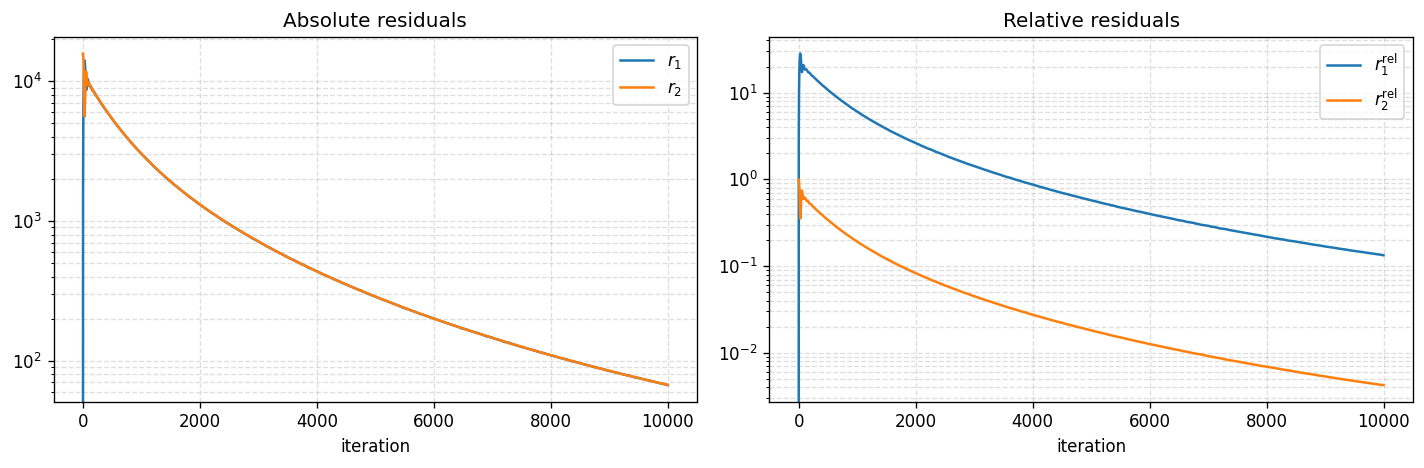

In [13]:
plot_residuals(residuals)

In [11]:
max(residuals["r1_rel"][:50]), max(residuals["r2_rel"][:50]), min(residuals["r1_rel"][:50]), min(residuals["r2_rel"][:50])

(29.643096237251275, 0.9999955269616737, 0.0, 0.3613727776956497)